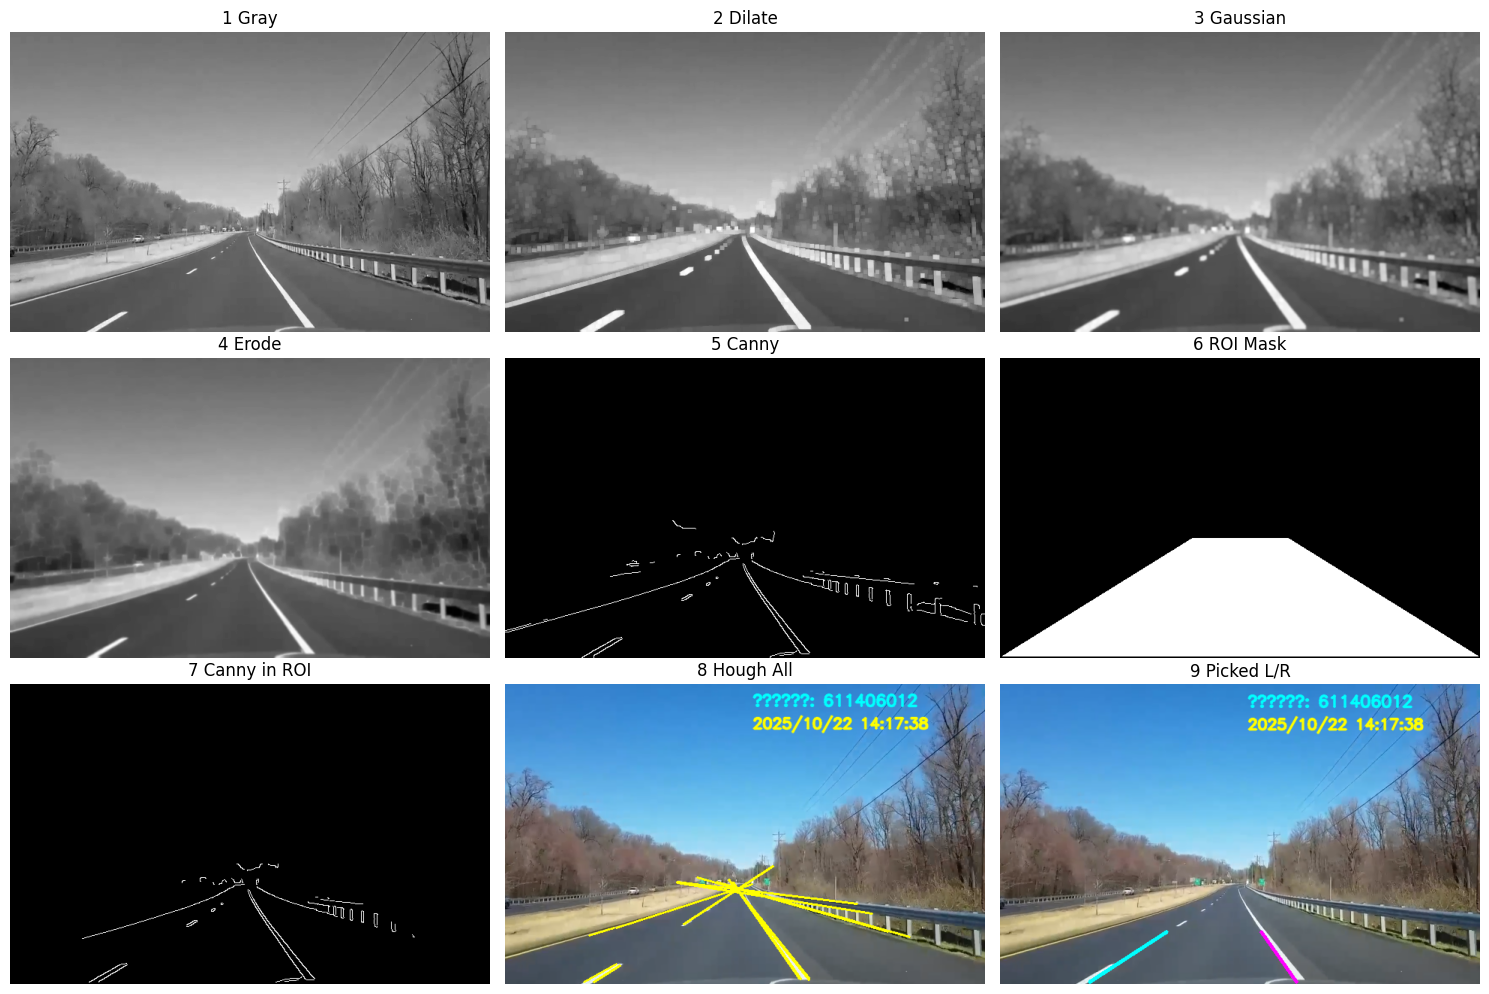

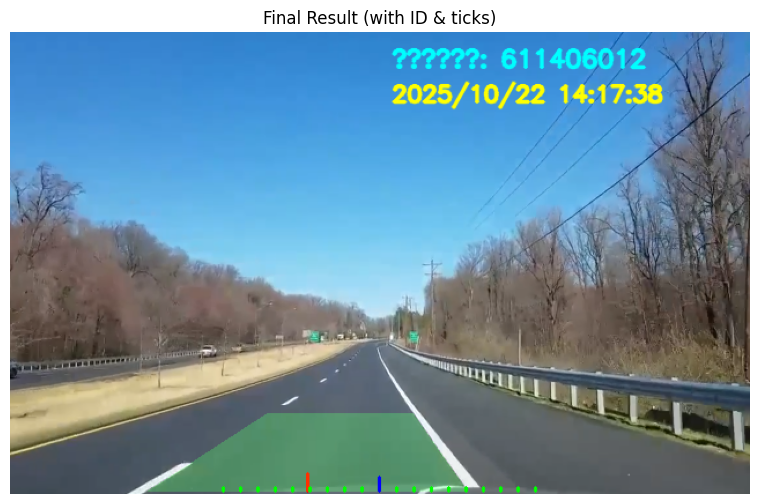

✅ 已輸出：step1~step9 與 result.jpg


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ====== 基本設定 ======
STU_ID = "學號: 611406012"
SRC_IMG = "road.png"
ww, hh, rh, r = 640, 400, 0.6, 3
xx1, yy1, xx2, yy2 = int(ww*0.4), int(hh*rh), int(ww*0.6), int(hh*rh)
p1, p2, p3, p4 = [r, hh-r], [ww-r, hh-r], [xx2, yy2], [xx1, yy2]
HOUGH_THRESHOLD, HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP = 40, 15, 70
# =====================

def bgr2rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def put_id_stamp(img_bgr):
    """右上角加學號與時間（所有輸出統一放水印）"""
    out = img_bgr.copy()
    ts = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    # 右上角位置
    h, w = out.shape[:2]
    cv2.putText(out, STU_ID, (w-310, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2, cv2.LINE_AA)
    cv2.putText(out, ts,      (w-310, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,255,255),2, cv2.LINE_AA)
    return out

# 讀圖
img0 = cv2.imread(SRC_IMG)
if img0 is None:
    raise FileNotFoundError(f"找不到 {SRC_IMG}")
img1 = cv2.resize(img0, (ww, hh))

# 1. 灰階
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
cv2.imwrite("step1_gray.jpg", gray)

# 2. 膨脹
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dil = cv2.dilate(gray, kernel)
cv2.imwrite("step2_dilate.jpg", dil)

# 3. 高斯模糊
blur = cv2.GaussianBlur(dil, (5, 5), 0)
cv2.imwrite("step3_gaussian.jpg", blur)

# 4. 侵蝕
ero = cv2.erode(blur, kernel)
cv2.imwrite("step4_erode.jpg", ero)

# 5. Canny
edge = cv2.Canny(ero, 150, 200)
cv2.imwrite("step5_canny.jpg", edge)

# 6. 產生 ROI
zero = np.zeros((hh, ww, 1), dtype='uint8')
pts_trap = np.array([p1, p2, p3, p4])
zone = cv2.fillPoly(zero.copy(), [pts_trap], 255)
cv2.imwrite("step6_roi_mask.jpg", zone)

# 7. Canny 套 ROI
edge_roi = cv2.bitwise_and(edge, zone)
cv2.imwrite("step7_roi.jpg", edge_roi)

# 8. Hough 全部線段
lines = cv2.HoughLinesP(edge_roi, 1, np.pi/180,
                        HOUGH_THRESHOLD, None,
                        HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP)

hough_all = img1.copy()
done, s1, s2, b1, b2 = 0, 0, 0, 0, 0    # 你的左右線挑選旗標與參數

if lines is not None:
    for i in range(len(lines)):
        x1, y1, x2, y2 = lines[i][0]
        # 畫在「Hough All Lines」圖上（黃色）
        cv2.line(hough_all, (x1, y1), (x2, y2), (0, 255, 255), 2)

        # 保留你挑左右線的邏輯
        if x2 == x1:
            continue
        s = (y2 - y1) / (x2 - x1)
        b = y1 - s * x1
        if min(x1, x2) < 30 or max(x1, x2) > ww - 30:
            continue
        if s < 0 and s < s1:
            done = done | 1
            s1, b1 = s, b
        if s > 0 and s > s2:
            done = done | 2
            s2, b2 = s, b

hough_all = put_id_stamp(hough_all)
cv2.imwrite("step8_hough_all.jpg", hough_all)

# 9. 只顯示「挑出的左右線」
picked_lr = img1.copy()
if done == 3:
    # 用兩條最佳線畫上去（青色左線、洋紅右線）
    # 取上下兩個 y 來畫延伸線
    yb, yt = hh - r, int(hh - hh*0.175)
    # left
    xlb = int((yb - b1) / s1); xlt = int((yt - b1) / s1)
    cv2.line(picked_lr, (xlb, yb), (xlt, yt), (255, 255, 0), 3)
    # right
    xrb = int((yb - b2) / s2); xrt = int((yt - b2) / s2)
    cv2.line(picked_lr, (xrb, yb), (xrt, yt), (255, 0, 255), 3)

picked_lr = put_id_stamp(picked_lr)
cv2.imwrite("step9_lr_lines.jpg", picked_lr)

# 10. 最終結果：填色 + 中心＆刻度（你的風格）
img2 = img1.copy()
if done == 3:
    yb, yt = hh - r, int(hh - hh*0.175)
    x_mid = int(((yb - b1)/s1 + (yb - b2)/s2) / 2)
    co = (255, 0, 0)   # 正常藍
    if abs(x_mid - (int(ww/2)-1)) > 45:
        co = (0, 0, 255)  # 偏離紅

    # 垂直短線（判斷偏離）
    cv2.line(img2, (x_mid, yb), (x_mid, yb-15), co, 2)

    # 車道填色（只在兩條線之間）
    p1f = (int((yb - b1) / s1), int(yb))
    p2f = (int((yt - b1) / s1), int(yt))
    p3f = (int((yt - b2) / s2), int(yt))
    p4f = (int((yb - b2) / s2), int(yb))
    mask_color = np.zeros((hh, ww, 3), dtype='uint8')
    cv2.fillPoly(mask_color, [np.array([p1f, p2f, p3f, p4f])], (0, 50, 0))
    img2 = cv2.addWeighted(img2, 1.0, mask_color, 1.0, 0)

# 中心藍線 + 左右綠刻度
x, y = int(ww/2)-1, hh-r
cv2.line(img2, (x, y), (x, y-12), (255, 0, 0), 2)
for i in range(1, 10):
    cv2.line(img2, (x-i*15, y), (x-i*15, y-3), (0, 255, 0), 2)
    cv2.line(img2, (x+i*15, y), (x+i*15, y-3), (0, 255, 0), 2)

img2 = put_id_stamp(img2)
cv2.imwrite("result.jpg", img2)

# ========== 用 matplotlib 一次排版顯示 ==========
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1); plt.title("1 Gray");         plt.imshow(gray, cmap='gray');              plt.axis('off')
plt.subplot(3, 3, 2); plt.title("2 Dilate");       plt.imshow(dil, cmap='gray');               plt.axis('off')
plt.subplot(3, 3, 3); plt.title("3 Gaussian");     plt.imshow(blur, cmap='gray');              plt.axis('off')
plt.subplot(3, 3, 4); plt.title("4 Erode");        plt.imshow(ero, cmap='gray');               plt.axis('off')
plt.subplot(3, 3, 5); plt.title("5 Canny");        plt.imshow(edge, cmap='gray');              plt.axis('off')
plt.subplot(3, 3, 6); plt.title("6 ROI Mask");     plt.imshow(zone, cmap='gray');              plt.axis('off')
plt.subplot(3, 3, 7); plt.title("7 Canny in ROI"); plt.imshow(edge_roi, cmap='gray');          plt.axis('off')
plt.subplot(3, 3, 8); plt.title("8 Hough All");    plt.imshow(bgr2rgb(hough_all));             plt.axis('off')
plt.subplot(3, 3, 9); plt.title("9 Picked L/R");   plt.imshow(bgr2rgb(picked_lr));             plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Final Result (with ID & ticks)")
plt.imshow(bgr2rgb(img2)); plt.axis('off')
plt.show()

print("✅ 已輸出：step1~step9 與 result.jpg")
